# Storytelling Parte 3: Analisando as relações entre a avaliaçao e o atraso


O objetivo desse trabalho é analisar se há a necessidade de aumento nos investimentos para o setor de entrega, para assim, melhorar a experiência do cliente

- Base de dados https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_customers_dataset.csv
<br><br>

- Algumas considerações são importantes
    - O **time de logística não considera que o atraso na entrega é um problema relevante** e falou que, em média, as entregas estão sendo feitas 10 dias antes do prazo combinado
    - Não é desejado a previsão de uma entrega atrasada, apenas a **exposição que esse é um problema que pode impactar os clientes**

### Criando o ambiente com SQL

In [68]:
# Importando as bibliotecas e pacotes
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from os import path
import datetime as dt
%pip install wordcloud
from wordcloud import WordCloud,STOPWORDS

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Criando uma conexão
con = sqlite3.connect('vendas_db.db')

In [5]:
# E então criando o cursor
cur = con.cursor()

In [6]:
# Usando a função python que já havíamos criado
def executa_consulta(consulta):
    resultado = cur.execute(consulta).fetchall()
    resultado = pd.DataFrame(resultado)
    colunas = [i[0] for i in cur.description]
    if resultado.shape[1] > 0:
        resultado.columns = colunas
    print(resultado.shape)
    display(resultado.head(3))
    return resultado

### Existe relação da avaliação do cliente com o atraso do pedido? </font>

In [7]:
# Vamos começar visualizando a tabela de avaliações
avaliacoes = executa_consulta('SELECT * FROM order_reviews')

(99224, 8)


,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24


In [8]:
# Verificando a quantidade de avaliações em cada uma das notas
avaliacoes.review_score.value_counts().sort_index()

1    11424
2     3151
3     8179
4    19142
5    57328
Name: review_score, dtype: int64

In [9]:
# Visualizando em percentual
round((avaliacoes.review_score.value_counts().sort_index()/avaliacoes.shape[0])*100,1)

1    11.5
2     3.2
3     8.2
4    19.3
5    57.8
Name: review_score, dtype: float64

In [10]:
# Podemos também visualizar a tabela de pedidos
pedidos = executa_consulta('SELECT * FROM orders')

(99441, 9)


,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [11]:
# Relacionando as duas tabelas
avaliacao_ordem = executa_consulta('SELECT * FROM orders o \
                                   LEFT JOIN order_reviews ore \
                                   ON o.order_id = ore.order_id')

(99992, 17)


,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,32790.0,a54f0611adc9ed256b57ede6b6eb5114,e481f51cbdc54678b7cc49136f2d6af7,4.0,None,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,29158.0,8d5266042046a06655c8db133d120ba5,53cdb2fc8bc7dce0b6741e2150273451,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
2,2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,4323.0,e73b67b67587f7644d5bd1a52deb1b01,47770eb9100c2d0c44946d9cf07ec65d,5.0,None,None,2018-08-18 00:00:00,2018-08-22 19:07:58


In [12]:
# Podemos pegar apenas as colunas que quisermos utilizar
avaliacao_ordem = executa_consulta('SELECT \
                                     o.order_id \
                                    ,o.order_purchase_timestamp \
                                    ,o.order_delivered_customer_date \
                                    ,o.order_estimated_delivery_date \
                                    ,ore.review_score \
                                   FROM orders o \
                                   LEFT JOIN order_reviews ore \
                                   ON o.order_id = ore.order_id')

(99992, 5)


,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00,5.0


In [13]:
# Analisando se todos os pedidos possuem avaliação?
avaliacao_ordem[avaliacao_ordem.review_score.isnull()]

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score
16,403b97836b0c04a622354cf531062e5f,2018-01-02 19:00:43,2018-01-20 01:38:59,2018-02-06 00:00:00,NaN
154,6942b8da583c2f9957e990d028607019,2018-01-10 11:33:07,None,2018-02-07 00:00:00,NaN
311,4906eeadde5f70b308c20c4a8f20be02,2017-12-08 04:45:26,2018-01-09 18:04:58,2018-01-03 00:00:00,NaN
382,b7a4a9ecb1cd3ef6a3e36a48e200e3be,2017-05-19 18:13:54,2017-06-08 07:53:42,2017-06-16 00:00:00,NaN
390,59b32faedc12322c672e95ec3716d614,2018-06-27 11:10:11,2018-07-06 16:37:36,2018-07-26 00:00:00,NaN
...,...,...,...,...,...
99242,0c384d67524b5b92aa2fa6c8baa9a983,2017-06-05 19:20:11,2017-06-13 14:09:21,2017-06-27 00:00:00,NaN
99327,906a6b0a96d89ee226e4977e99b80b9e,2017-08-28 15:14:21,2017-09-05 19:47:44,2017-09-18 00:00:00,NaN
99554,5333db16fe357175d39c82840dd3269d,2018-03-10 18:18:20,2018-04-03 15:32:52,2018-03-29 00:00:00,NaN
99684,2f2df159f26ddb73d55ee72372200d3e,2017-07-17 01:19:50,2017-07-26 09:44:00,2017-08-09 00:00:00,NaN


In [14]:
# Verificando a diferença entre as duas tabelas
pedidos.shape[0] - avaliacoes.shape[0]

217

**Temos 768 pedidos sem avaliação mas apenas 217 linhas a mais**<br>
**Podemos analisar se algum pedido possui mais de 1 avaliação?**<br>

In [15]:
# Visualizando se alguma ordem apareceu mais de 1 vez
avaliacao_ordem.order_id.value_counts()

8e17072ec97ce29f0e1f111e598b0c85    3
03c939fd7fd3b38f8485a0f95798f1f6    3
c88b1d1b157a9999ce368f218a407141    3
df56136b8031ecd28e200bb18e6ddb2e    3
95442deb81a5d91c97c0df96b431634a    2
                                   ..
94a1020970476388adf12c46628499be    1
b266c12d9bececa3942c1bef84f13716    1
e82e0697786dcef38c215ec9d2dc308a    1
e940e33cefca8e48b759474760c2fb41    1
66dea50a8b16d9b4dee7af250b4be1a5    1
Name: order_id, Length: 99441, dtype: int64

In [16]:
# Verificando essa primeira ordem na tabela de pedidos
pedidos[pedidos.order_id == 'c88b1d1b157a9999ce368f218a407141']

,index,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
37179,37179,c88b1d1b157a9999ce368f218a407141,ae0fb7b01c548c4fd30f19f55453ec4a,delivered,2017-07-17 22:44:23,2017-07-18 22:50:12,2017-07-20 15:27:41,2017-07-21 17:06:30,2017-08-01 00:00:00


In [17]:
# Agora verificando na tabela de avaliações
avaliacoes[avaliacoes.order_id == 'c88b1d1b157a9999ce368f218a407141']

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
1985,1985,ffb8cff872a625632ac983eb1f88843c,c88b1d1b157a9999ce368f218a407141,3,None,None,2017-07-22 00:00:00,2017-07-26 13:41:07
82525,82525,202b5f44d09cd3cfc0d6bd12f01b044c,c88b1d1b157a9999ce368f218a407141,5,None,None,2017-07-22 00:00:00,2017-07-26 13:40:22
89360,89360,fb96ea2ef8cce1c888f4d45c8e22b793,c88b1d1b157a9999ce368f218a407141,5,None,None,2017-07-21 00:00:00,2017-07-26 13:45:15


In [18]:
avaliacao_ordem[avaliacao_ordem.order_id == 'c88b1d1b157a9999ce368f218a407141']

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_score
37365,c88b1d1b157a9999ce368f218a407141,2017-07-17 22:44:23,2017-07-21 17:06:30,2017-08-01 00:00:00,3.0
37366,c88b1d1b157a9999ce368f218a407141,2017-07-17 22:44:23,2017-07-21 17:06:30,2017-08-01 00:00:00,5.0
37367,c88b1d1b157a9999ce368f218a407141,2017-07-17 22:44:23,2017-07-21 17:06:30,2017-08-01 00:00:00,5.0


**Procurando os registros com mais de 1 linha com a média**

In [19]:
# E se usarmos a média?
media = avaliacao_ordem.groupby('order_id')['review_score'].mean().reset_index()
media.columns = ['order_id','media_nota']

In [20]:
# Verificando as notas
media.media_nota.value_counts().sort_index()

1.000000    11316
1.500000        8
2.000000     3125
2.500000       34
3.000000     8136
3.333333        1
3.500000       25
4.000000    19018
4.333333        1
4.500000       54
5.000000    56955
Name: media_nota, dtype: int64

**Verificando com o máximo**

In [21]:
# E se usarmos o máximo?
maximo = avaliacao_ordem.groupby('order_id')['review_score'].max().reset_index()
maximo.columns = ['order_id','maximo_nota']

In [22]:
# Verificando as notas
maximo.maximo_nota.value_counts().sort_index()

1.0    11316
2.0     3121
3.0     8116
4.0    19044
5.0    57076
Name: maximo_nota, dtype: int64

**Trazendo do SQL tanto a média quanto o máximo e então aprofundar na análise**

In [23]:
# Primeiramente fazendo o join entre as tabelas
avaliacao_ordem = executa_consulta('SELECT \
                                     o.order_id \
                                    ,o.order_purchase_timestamp \
                                    ,o.order_delivered_customer_date \
                                    ,o.order_estimated_delivery_date \
                                    ,ROUND(AVG(ore.review_score),1) as media_nota \
                                    ,ROUND(MAX(ore.review_score),1) as maximo_nota \
                                   FROM orders o \
                                   LEFT JOIN order_reviews ore \
                                   ON o.order_id = ore.order_id \
                                   WHERE ore.review_score IS NOT NULL \
                                   GROUP BY \
                                     o.order_id \
                                    ,o.order_purchase_timestamp \
                                    ,o.order_delivered_customer_date \
                                    ,o.order_estimated_delivery_date')

(98673, 6)


,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,media_nota,maximo_nota
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29 00:00:00,5.0,5.0
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15 00:00:00,4.0,4.0
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05 00:00:00,5.0,5.0


In [24]:
# Verificando as informações da base
avaliacao_ordem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98673 entries, 0 to 98672
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       98673 non-null  object 
 1   order_purchase_timestamp       98673 non-null  object 
 2   order_delivered_customer_date  95830 non-null  object 
 3   order_estimated_delivery_date  98673 non-null  object 
 4   media_nota                     98673 non-null  float64
 5   maximo_nota                    98673 non-null  float64
dtypes: float64(2), object(4)
memory usage: 4.5+ MB


In [25]:
# Transformando as colunas de data em datas
colunas_datas = ['order_purchase_timestamp','order_delivered_customer_date','order_estimated_delivery_date']

for i in colunas_datas:
    avaliacao_ordem[i] = pd.to_datetime(avaliacao_ordem[i], format='%Y-%m-%d %H:%M:%S')

In [26]:
# Verificando novamente as informações da base
avaliacao_ordem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98673 entries, 0 to 98672
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98673 non-null  object        
 1   order_purchase_timestamp       98673 non-null  datetime64[ns]
 2   order_delivered_customer_date  95830 non-null  datetime64[ns]
 3   order_estimated_delivery_date  98673 non-null  datetime64[ns]
 4   media_nota                     98673 non-null  float64       
 5   maximo_nota                    98673 non-null  float64       
dtypes: datetime64[ns](3), float64(2), object(1)
memory usage: 4.5+ MB


In [27]:
# Verificando as primeiras linhas da tabela
avaliacao_ordem.head(3)

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,media_nota,maximo_nota
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29,5.0,5.0
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15,4.0,4.0
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05,5.0,5.0


In [28]:
# Analisando o impacto de usar o máximo ao invés da média
avaliacao_ordem.groupby(['media_nota','maximo_nota'])['order_id'].count()

media_nota  maximo_nota
1.0         1.0            11316
1.5         2.0                8
2.0         2.0             3113
            3.0               12
2.5         3.0               10
            4.0               24
3.0         3.0             8094
            4.0                9
            5.0               33
3.3         4.0                1
3.5         4.0               17
            5.0                8
4.0         4.0            18993
            5.0               25
4.3         5.0                1
4.5         5.0               54
5.0         5.0            56955
Name: order_id, dtype: int64

In [29]:
# Retirando quando maximo é igual a média
avaliacao_ordem[avaliacao_ordem.media_nota != avaliacao_ordem.maximo_nota].groupby(['media_nota','maximo_nota'])['order_id'].count()

media_nota  maximo_nota
1.5         2.0             8
2.0         3.0            12
2.5         3.0            10
            4.0            24
3.0         4.0             9
            5.0            33
3.3         4.0             1
3.5         4.0            17
            5.0             8
4.0         5.0            25
4.3         5.0             1
4.5         5.0            54
Name: order_id, dtype: int64

In [30]:
# Verificando o % dessas notas
avaliacao_ordem[avaliacao_ordem.media_nota != avaliacao_ordem.maximo_nota].shape[0]/avaliacao_ordem.shape[0]

0.002047165891378594

**Podemos definir com o negócio que vamos utilizar o máximo da nota**

In [31]:
# Vamos considerar uma única coluna de nota
avaliacao_ordem['nota'] = avaliacao_ordem.maximo_nota

In [32]:
# E apagar as outras colunas para evitar confusão
avaliacao_ordem = avaliacao_ordem.drop(['media_nota','maximo_nota'],axis=1)

In [33]:
avaliacao_ordem.head(3)

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,nota
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29,5.0
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15,4.0
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05,5.0


### <font color='blue'>Agora sim vamos responder a pergunta da relação entre o atraso e a avaliação</font>

In [35]:
# Calculando o atraso na entrega
avaliacao_ordem['atraso'] = (avaliacao_ordem.order_estimated_delivery_date.dt.date - avaliacao_ordem.order_delivered_customer_date.dt.date).dt.days

In [36]:
# Marcando entregas que tiveram atraso com uma marcação (flag)
avaliacao_ordem['flag_atraso'] = avaliacao_ordem.atraso.apply(lambda x: 1 if x < 0 else 0)

In [37]:
# Verificando novamente a base
avaliacao_ordem.head(3)

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,nota,atraso,flag_atraso
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29,5.0,9.0,0
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15,4.0,3.0,0
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05,5.0,14.0,0


In [38]:
# Verificando a nota quando existe atraso e quando não existe atraso
avaliacao_ordem.groupby('flag_atraso')['nota'].mean()

flag_atraso
0    4.214376
1    2.274052
Name: nota, dtype: float64

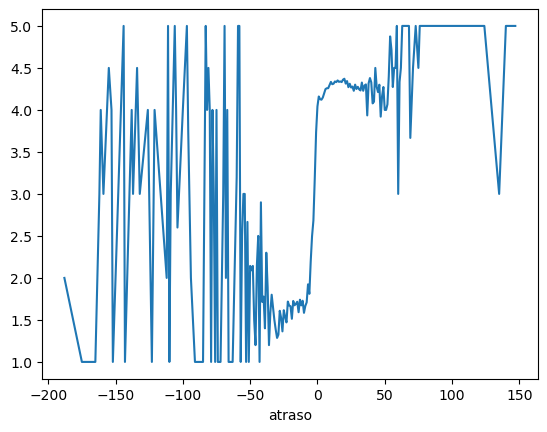

In [39]:
# Analisando os atrasos em relação a média das notas
avaliacao_ordem.groupby('atraso')['nota'].mean().plot();

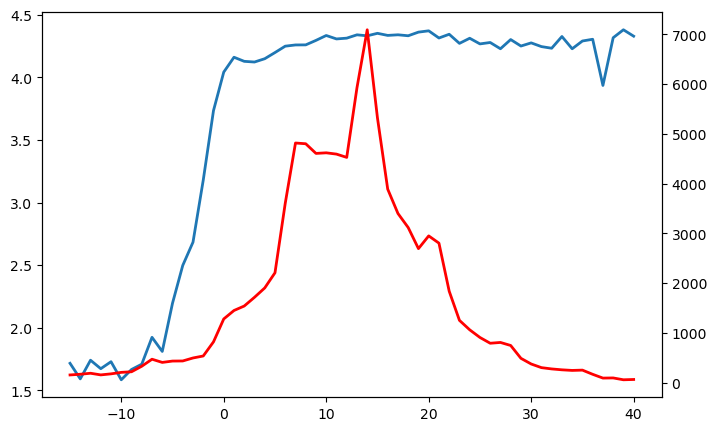

In [40]:
# Melhorando o gráfico e visualizando a quantidade de registros em cada dia
fig, ax = plt.subplots(figsize=(8,5))

base2 = avaliacao_ordem[(avaliacao_ordem.atraso >= -15) & (avaliacao_ordem.atraso <= 40)]

media_notas = base2.groupby('atraso')['nota'].mean()
qtd_avaliacoes = base2.groupby('atraso')['nota'].count()

ax2 = ax.twinx()

ax.plot(media_notas.index, media_notas.values, linewidth=2.0)
ax2.plot(qtd_avaliacoes.index, qtd_avaliacoes.values, linewidth=2.0,c='r')

plt.show()

In [44]:
# Usando a função já pronta apenas para adiantar a escrita do código
def agrupa_atraso(atraso):
    if atraso < -20:
        return '01. Mais de 20 dias de atraso'
    elif atraso < -15:
        return '02. Entre 15 e 20 dias de atraso'
    elif atraso < -10:
        return '03. Entre 10 e 15 dias de atraso'
    elif atraso < -8:
        return '04. Entre 8 e 10 dias de atraso'
    elif atraso < -6:
        return '05. Entre 6 e 8 dias de atraso'
    elif atraso < -4:
        return '06. Entre 4 e 6 dias de atraso'
    elif atraso < -2:
        return '07. Entre 2 e 4 dias de atraso'
    elif atraso < 0:
        return '08. Entre 1 e 2 dias de atraso'
    elif atraso == 0:
        return '09. Entregue na data'
    elif atraso <= 2:
        return '10. Entre 0 e 2 dias antes do prazo'
    elif atraso <= 4:
        return '11. Entre 2 e 4 dias antes do prazo'
    elif atraso <= 6:
        return '12. Entre 4 e 6 dias antes do prazo' 
    elif atraso <= 8:
        return '13. Entre 6 e 8 dias antes do prazo' 
    elif atraso <= 10:
        return '14. Entre 8 e 10 dias antes do prazo' 
    elif atraso <= 15:
        return '15. Entre 10 e 15 dias antes do prazo' 
    elif atraso <= 20:
        return '16. Entre 15 e 20 dias antes do prazo' 
    elif atraso <= 30:
        return '17. Entre 20 e 30 dias antes do prazo' 
    elif atraso <= 40:
        return '18. Entre 30 e 40 dias antes do prazo' 
    elif atraso > 40:
        return '19. Mais de 40 dias antes do prazo' 
    else:
        return '20. Verificar'

In [45]:
# Aplicando novamente a função
avaliacao_ordem['grupo_atraso'] = avaliacao_ordem.atraso.apply(agrupa_atraso)

In [46]:
# Visualizando a base
avaliacao_ordem.head()

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,nota,atraso,flag_atraso,grupo_atraso
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29,5.0,9.0,0,14. Entre 8 e 10 dias antes do prazo
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15,4.0,3.0,0,11. Entre 2 e 4 dias antes do prazo
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,2018-01-22 13:19:16,2018-02-05,5.0,14.0,0,15. Entre 10 e 15 dias antes do prazo
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,2018-08-14 13:32:39,2018-08-20,4.0,6.0,0,12. Entre 4 e 6 dias antes do prazo
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,2017-03-01 16:42:31,2017-03-17,5.0,16.0,0,16. Entre 15 e 20 dias antes do prazo


In [47]:
# Verificando as avaliações que não conseguimos analisar a data
avaliacao_ordem[avaliacao_ordem.grupo_atraso == '20. Verificar']

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,nota,atraso,flag_atraso,grupo_atraso
24,0010dedd556712d7bb69a19cb7bbd37a,2017-10-21 19:32:06,NaT,2017-11-03,1.0,NaN,0,20. Verificar
72,002f19a65a2ddd70a090297872e6d64e,2018-03-21 13:05:30,NaT,2018-04-16,3.0,NaN,0,20. Verificar
76,00310b0c75bb13015ec4d82d341865a4,2018-08-15 14:29:08,NaT,2018-08-29,1.0,NaN,0,20. Verificar
227,00a500bc03bc4ec968e574c2553bed4b,2017-11-23 10:53:01,NaT,2018-01-08,2.0,NaN,0,20. Verificar
233,00a99c50fdff7e36262caba33821875a,2018-08-17 16:25:04,NaT,2018-09-18,5.0,NaN,0,20. Verificar
...,...,...,...,...,...,...,...,...
98324,ff0768e3356919b32e3d7f30baecfcfb,2018-04-04 22:58:39,NaT,2018-04-23,1.0,NaN,0,20. Verificar
98396,ff358345576214cc9e08488188973c84,2018-03-03 17:05:12,NaT,2018-04-02,1.0,NaN,0,20. Verificar
98437,ff536d93ae4214b4d51c2894ccfc569f,2017-12-21 09:01:00,NaT,2018-01-10,3.0,NaN,0,20. Verificar
98471,ff7140ba310a4717112d39c0cd0b4062,2017-05-19 18:11:21,NaT,2017-06-26,1.0,NaN,0,20. Verificar


In [48]:
# Podemos retirar da base as linhas que não são do nosso interesse
avaliacao_ordem = avaliacao_ordem[avaliacao_ordem.grupo_atraso != '20. Verificar']

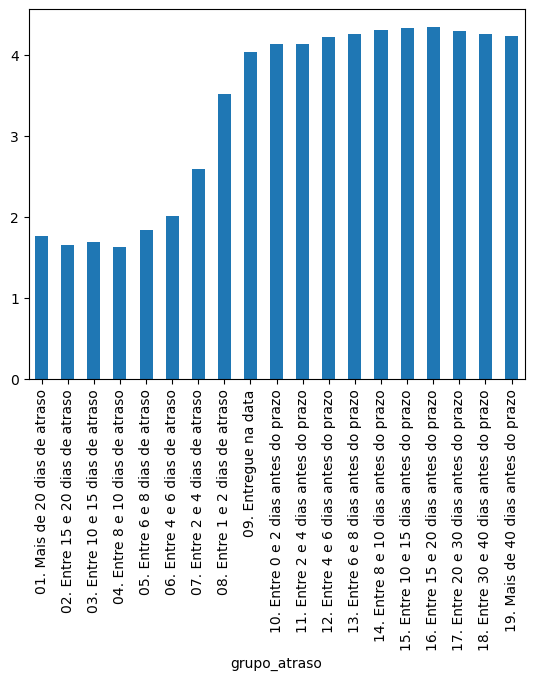

In [49]:
# Analisando a média das notas por faixa de atraso
avaliacao_ordem.groupby('grupo_atraso')['nota'].mean().plot.bar();

**Depois que você já visualizou essa informação, pense na melhor maneira de apresentar**

In [50]:
# Salvando em uma variavel
base_nova = avaliacao_ordem[(avaliacao_ordem.atraso >= -10) & (avaliacao_ordem.atraso <= 10)]

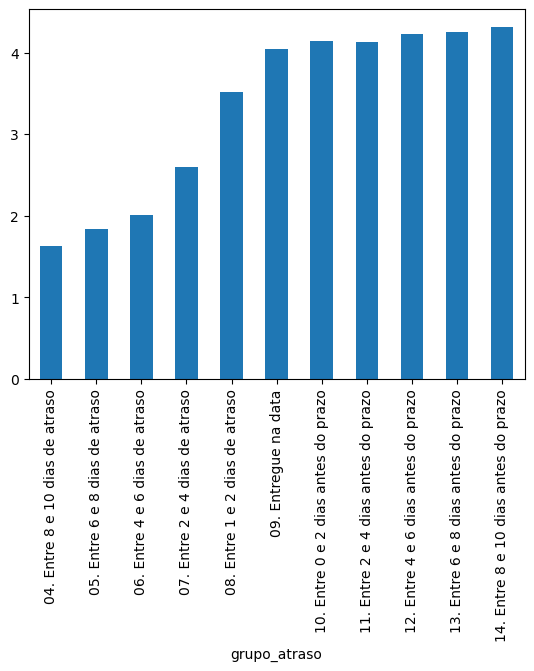

In [51]:
# Visualizando graficamente
valores_grafico = base_nova.groupby('grupo_atraso')['nota'].mean()
valores_grafico.plot.bar();

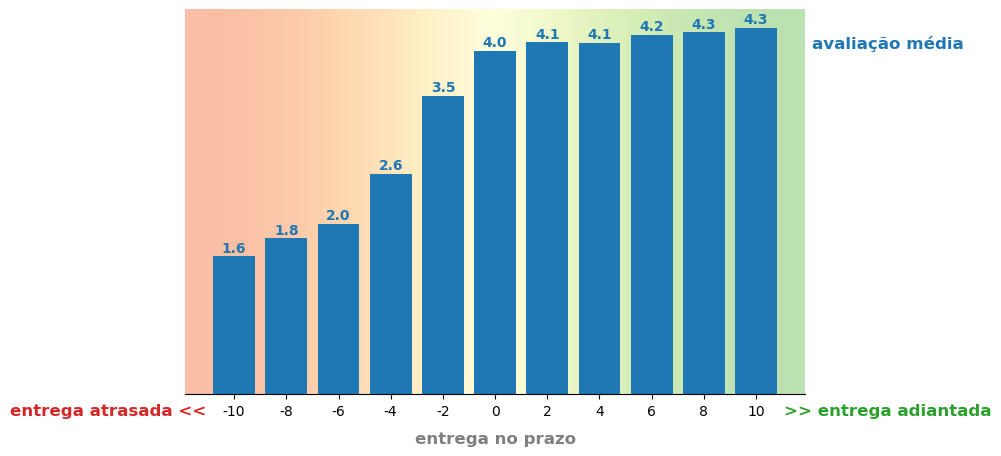

In [52]:
# Melhorando a visualização

np.random.seed(19680801)


def gradient_image(ax, direction=0.3, cmap_range=(0, 1), **kwargs):
    """
    Draw a gradient image based on a colormap.

    Parameters
    ----------
    ax : Axes
        The axes to draw on.
    direction : float
        The direction of the gradient. This is a number in
        range 0 (=vertical) to 1 (=horizontal).
    cmap_range : float, float
        The fraction (cmin, cmax) of the colormap that should be
        used for the gradient, where the complete colormap is (0, 1).
    **kwargs
        Other parameters are passed on to `.Axes.imshow()`.
        In particular, *cmap*, *extent*, and *transform* may be useful.
    """
    phi = direction * np.pi / 2
    v = np.array([np.cos(phi), np.sin(phi)])
    X = np.array([[v @ [1, 0], v @ [1, 1]],
                  [v @ [0, 0], v @ [0, 1]]])
    a, b = cmap_range
    X = a + (b - a) / X.max() * X
    im = ax.imshow(X, interpolation='bicubic', clim=(0, 1),
                   aspect='auto', **kwargs)
    return im


def gradient_bar(ax, x, y, width=0.5, bottom=0):
    for left, top in zip(x, y):
        right = left + width
        gradient_image(ax, extent=(left, right, bottom, top),
                       cmap=plt.cm.Blues_r, cmap_range=(0, 0.8))

fig, ax = plt.subplots(figsize=(8,5))

# background image
gradient_image(ax, direction=1, extent=(0, 1, 0, 1), transform=ax.transAxes,
               cmap=plt.cm.RdYlGn, cmap_range=(0.2, 0.8), alpha=0.5)


x = np.arange(0,len(valores_grafico))

ax.bar(x,valores_grafico.values,color='tab:blue')

for i in range(0,len(valores_grafico)):
    ax.annotate(round(valores_grafico.values[i],1),(x[i],valores_grafico.values[i]),ha="center",xytext=(0,3),
               textcoords="offset points",c='tab:blue',fontsize=10,fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels([-10,-8,-6,-4,-2,0,2,4,6,8,10])
ax.yaxis.set_visible(False)    
    
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.annotate('avaliação média',(x[-1],valores_grafico.values[-1]),ha="left",xytext=(40,-15),
               textcoords="offset points",c='tab:blue',fontsize=12,fontweight='bold')
ax.annotate('entrega atrasada <<',(x[0],0),ha="right",xytext=(-20,-15),
               textcoords="offset points",c='tab:red',fontsize=12,fontweight='bold')
ax.annotate('>> entrega adiantada',(x[-1],0),ha="left",xytext=(+20,-15),
               textcoords="offset points",c='tab:green',fontsize=12,fontweight='bold')
ax.annotate('entrega no prazo',(x[5],0),ha="center",xytext=(0,-35),
               textcoords="offset points",c='tab:gray',fontsize=12,fontweight='bold')

plt.savefig('avaliacoes',bbox_inches = 'tight', transparent=True)

### <font color='blue'> 3. Como posso saber que as avaliações realmente reclamavam da entrega? </font>

In [53]:
# Verificando novamente a nossa base já tratada
base_nova.head()

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,nota,atraso,flag_atraso,grupo_atraso
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,2017-09-20 23:43:48,2017-09-29,5.0,9.0,0,14. Entre 8 e 10 dias antes do prazo
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,2017-05-12 16:04:24,2017-05-15,4.0,3.0,0,11. Entre 2 e 4 dias antes do prazo
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,2018-08-14 13:32:39,2018-08-20,4.0,6.0,0,12. Entre 4 e 6 dias antes do prazo
8,0005a1a1728c9d785b8e2b08b904576c,2018-03-19 18:40:33,2018-03-29 18:17:31,2018-03-29,1.0,0.0,0,09. Entregue na data
11,00063b381e2406b52ad429470734ebd5,2018-07-27 17:21:27,2018-08-07 13:56:52,2018-08-07,5.0,0.0,0,09. Entregue na data


In [54]:
# E a base de avaliações
avaliacoes.head()

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24
3,3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,None,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,None,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [55]:
# Pegando os ids das ordens entre 10 e 5 dias de atraso (as 3 primeiras colunas)
ids_atraso = base_nova.loc[base_nova.atraso <= -5, 'order_id']

In [56]:
# Verificando as avaliações desses pedidos
avaliacoes[avaliacoes.order_id.isin(ids_atraso)]

,index,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
32,32,58044bca115705a48fe0e00a21390c54,68e55ca79d04a79f20d4bfc0146f4b66,1,None,Sempre compro pela Internet e a entrega ocorre...,2018-04-08 00:00:00,2018-04-09 12:22:39
39,39,9fd59cd04b42f600df9f25e54082a8d1,3c314f50bc654f3c4e317b055681dff9,1,None,Nada de chegar o meu pedido.,2017-04-21 00:00:00,2017-04-23 05:37:03
45,45,3dc0777d97733a1d066f5b781e91577f,44a9994228432b835c3a4e720b6a41ab,4,None,None,2018-03-29 00:00:00,2018-03-31 00:13:07
106,106,d23ac17822a812782cf7f848b2a8b38b,705402bc1d956067338873d414158d09,1,None,None,2018-04-22 00:00:00,2018-04-26 10:25:11
168,168,d7ea05bb4f9c77d606fd90b1a27e317d,bb5b0d8f3e9c964760c674f2aa2ae0cf,1,None,Comprei o produto dia 25 de fevereiro e hoje d...,2018-03-29 00:00:00,2018-03-29 23:13:58
...,...,...,...,...,...,...,...,...
99091,99091,fade356e7332606aa22776d8d553cdce,837b75362f8a7c08c85182dfd16cb72d,1,None,Ainda nao recevi o produto.,2018-08-12 00:00:00,2018-08-12 13:51:31
99094,99094,9bab7509047d0b236205e330172b384d,e78cde66f03731202b0f5e082b0b0cff,1,None,Gostaria de saber porque meu produto ainda não...,2018-03-29 00:00:00,2018-03-29 22:21:55
99098,99098,d2aabe46dcbed6312ac19c0d5bc581bf,cdbe57b33f10dd54db2421744ab4a045,5,None,muito bom! recomendo!,2017-09-01 00:00:00,2017-09-01 18:27:53
99144,99144,e5a991ae8286f513e512f0f9fd188f9b,fadb25c91522130892be8a5ddb3e139f,1,None,None,2018-04-14 00:00:00,2018-04-16 18:37:40


In [57]:
# Visualizando esses comentários
avaliacoes.loc[avaliacoes.order_id.isin(ids_atraso), 'review_comment_message']

32       Sempre compro pela Internet e a entrega ocorre...
39                            Nada de chegar o meu pedido.
45                                                    None
106                                                   None
168      Comprei o produto dia 25 de fevereiro e hoje d...
                               ...                        
99091                          Ainda nao recevi o produto.
99094    Gostaria de saber porque meu produto ainda não...
99098                                muito bom! recomendo!
99144                                                 None
99174                                                 None
Name: review_comment_message, Length: 2078, dtype: object

In [58]:
for i in avaliacoes.loc[avaliacoes.order_id.isin(ids_atraso), 'review_comment_message']:
    print(i)

Sempre compro pela Internet e a entrega ocorre antes do prazo combinado, que acredito ser o prazo máximo. No stark o prazo máximo já se esgotou e ainda não recebi o produto.
Nada de chegar o meu pedido.
None
None
Comprei o produto dia 25 de fevereiro e hoje dia 29 de marco não fora entregue na minha residência. Não sei se os correios desse Brasil e péssimo ou foi a própria loja que demorou postar.
None
Não posso! Estou aguardando a chegada do produto que comprei!Logo que isso aconteça, terei minha opinião formada!
Comprei dois produtos e recebi somente um. Mandei dois emails para a loja e não tive nenhum retorno. Estou insatisfeita.
Até agora nao recebi.Comprei este aparelho por questao de saude,portanto nao recomendo esta loja.
comprei um produto para ser entregue por essa loja
e ainda não recebi
pois assim já se passou a data de entrega
None
Até agora não recebi nada, a colcha estava prevista para anteontem(18/12) e até agora nada
None
None
None
Até o momento eu n recebir o produto
N

In [61]:
#Transformando todos os comentários em um único texto
texto = ''
for i in avaliacoes.loc[avaliacoes.order_id.isin(ids_atraso), 'review_comment_message']:
    if i:
        texto += i
        texto += ''

In [62]:
#gerando nuvem de palavras
wordcloud = WordCloud(stopwords = ['o', 'a', 'que', 'com', 'e', 'de', 'da', 'dia'] ).generate(texto)

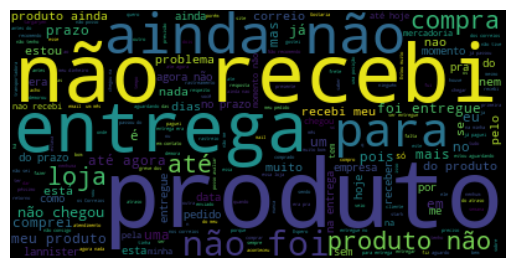

In [63]:
#Exibindo a imagem
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [65]:
# agrupando por frases
texto = ''
for i in avaliacoes.loc[avaliacoes.order_id.isin(ids_atraso), 'review_comment_message']:
    if i:
        i = i.replace(' ', '')
        texto += i
        texto += ''

In [66]:
texto

'SemprecompropelaInterneteaentregaocorreantesdoprazocombinado,queacreditoseroprazomáximo.Nostarkoprazomáximojáseesgotoueaindanãorecebioproduto.Nadadechegaromeupedido.Compreioprodutodia25defevereiroehojedia29demarconãoforaentreguenaminharesidência.NãoseiseoscorreiosdesseBrasilepéssimooufoiapróprialojaquedemoroupostar.Nãoposso!Estouaguardandoachegadadoprodutoquecomprei!Logoqueissoaconteça,tereiminhaopiniãoformada!Compreidoisprodutoserecebisomenteum.Mandeidoisemailsparaalojaenãotivenenhumretorno.Estouinsatisfeita.Atéagoranaorecebi.Compreiesteaparelhoporquestaodesaude,portantonaorecomendoestaloja.compreiumprodutoparaserentregueporessaloja\r\neaindanãorecebi\r\npoisassimjásepassouadatadeentregaAtéagoranãorecebinada,acolchaestavaprevistaparaanteontem(18/12)eatéagoranadaAtéomomentoeunrecebiroprodutoNãorecebioproduto.eagora?Precisodeumaprevisão.Recebioutraboneca,querodevolverenãoconsigocontato!Jamaiscomprarianovamentedessaloja!Estouesperandohámaisdevintediaseaindanãorecebimeuprodutoenãoconsigo

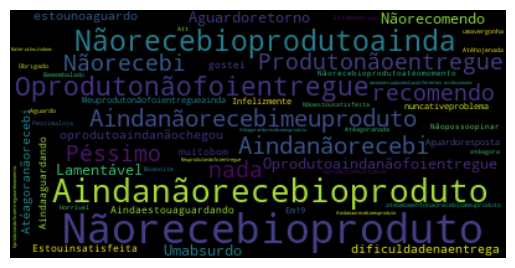

In [67]:
#gerando nova nuvem de palavras
wordcloud = wordcloud = WordCloud(stopwords = ['o', 'a', 'que', 'com', 'mas', 'e', 'de', 'da', 'bomdia', 
                                               'porém', 'mail'] ).generate(texto)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.savefig('pedidos_atrasados',bbox_inches = 'tight', transparent=True)